# Load and plot measured skew-spectra for multiple densities/catalogs#

In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d

plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [2]:
theo_basedir = '../data/azadeh_11sep2020/'
Rsmooth = 10.
poles = [0]

# Sims: read options
sim_seeds = range(400,406)
#sim_seeds = [400]
boxsize = 1500.
Ngrid = 512
APPLY_RSD = 1
# 0.0015 or 0.04 or None (for initial runs that used 0.0015 subsample)
subsample_ratio = 0.04

# None (old code), 'catalog', 'delta_2SPT'
density_source_lst = ['delta_2SPT', 'catalog']
velocity_source_lst = [None, 'DM_sim']
maximum_displacement_lst = [None, 100.0]

# if density_source in [None,'catalog']:
#     # velocity source: DM_sim (or '' in old runs), deltalin_D2, deltalin_D2_SPT2
#     velocity_source = 'DM_sim'
#     # max RSD displacement
#     maximum_displacement = 100.0   # don't use None any more, bug!
# else:
#     velocity_source = None
#     maximum_displacement = None

# z=0 to z=0.6 in ms_gadget cosmology
z_rescalefac = 0.7336055475

## Read and plot Azadeh theory ##

In [3]:
Ptheo = np.genfromtxt(os.path.join(theo_basedir, 'p_deltadelta.txt'), names=True)

In [4]:
Ptheo.dtype

dtype([('k', '<f8'), ('P_link', '<f8'), ('P_0k', '<f8'), ('P_2k', '<f8'), ('P_4k', '<f8')])

In [5]:
realnames = ['k'] + ['S%dp_lin' %d for d in range(1,15)]
Sn_real_theo = np.genfromtxt(os.path.join(theo_basedir, 'Sn_real_R%d.txt' % int(Rsmooth)), names=realnames)
Sn_rsd_theo = OrderedDict()
for ell in poles:
    rsdnames = ['k'] + ['S%d' % d for d in range(1,15)]
    Sn_rsd_theo[(ell,)] = np.genfromtxt(os.path.join(theo_basedir, 'Sn_rsd_%d_R%d.txt' % (ell,int(Rsmooth))), names=rsdnames)
    print(Sn_rsd_theo[(ell,)].dtype.names)

('k', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14')


In [6]:
print(Sn_real_theo.dtype.names)

('k', 'S1p_lin', 'S2p_lin', 'S3p_lin', 'S4p_lin', 'S5p_lin', 'S6p_lin', 'S7p_lin', 'S8p_lin', 'S9p_lin', 'S10p_lin', 'S11p_lin', 'S12p_lin', 'S13p_lin', 'S14p_lin')


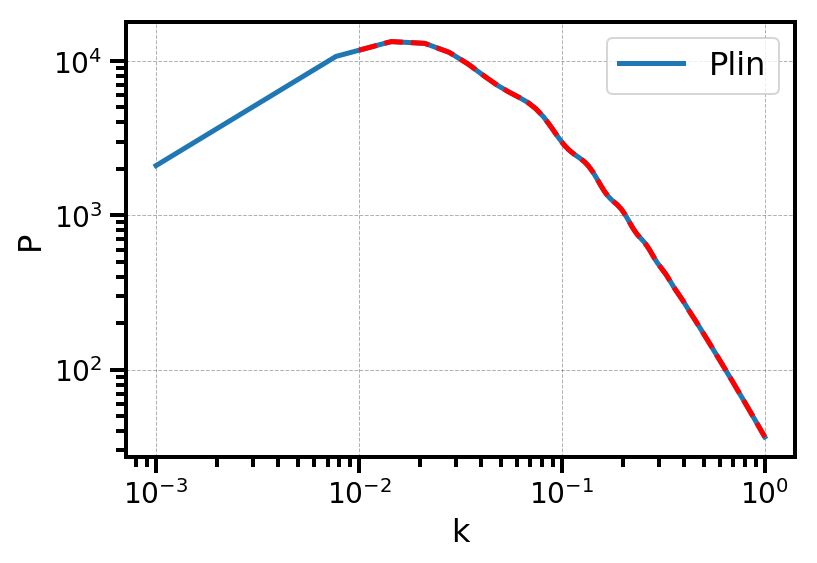

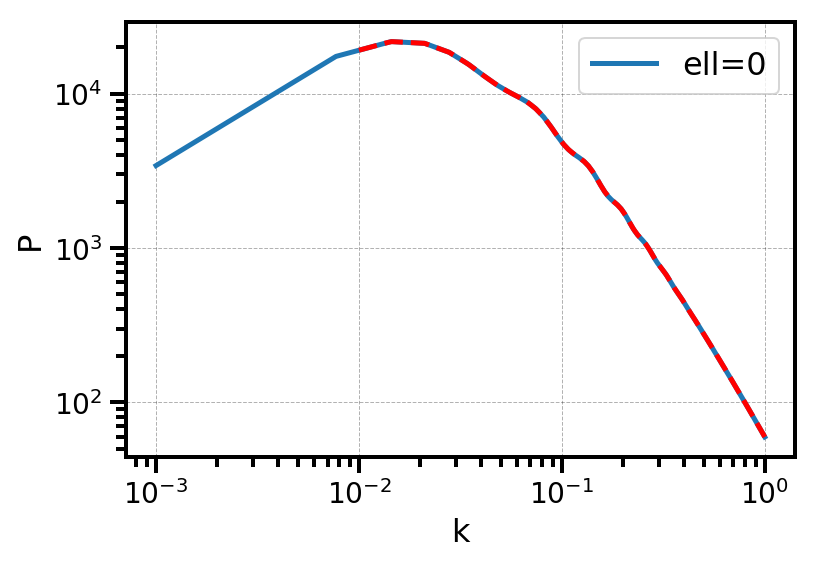

In [7]:
# plot Plin azadeh
# interp_lnPtheo_lnk = OrderedDict()
# interp_Ptheo_k = OrderedDict()
# for key in Ptheo.dtype.names:
#     if key == 'k':
#         continue
#     interp_lnPtheo_lnk[key] = interp1d(np.log(Ptheo['k']), np.log(Ptheo[key]))
#     interp_Ptheo_k[key] = lambda k: np.exp(interp_lnPtheo_lnk[key](np.log(k)))
    
interp_lnPtheo_lnk_Plin = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_link']))
interp_Ptheo_k_Plin = lambda k: np.exp(interp_lnPtheo_lnk_Plin(np.log(k)))
if 0 in poles:
    interp_lnPtheo_lnk_P0 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_0k']))
    interp_Ptheo_k_P0 = lambda k: np.exp(interp_lnPtheo_lnk_P0(np.log(k)))
if 2 in poles:
    interp_lnPtheo_lnk_P2 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_2k']))
    interp_Ptheo_k_P2 = lambda k: np.exp(interp_lnPtheo_lnk_P2(np.log(k)))
if 4 in poles:
    interp_lnPtheo_lnk_P4 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_4k']))
    interp_Ptheo_k_P4 = lambda k: np.exp(interp_lnPtheo_lnk_P4(np.log(k)))


# plot Plin
plt.subplots(figsize=(6,4))
plt.loglog(Ptheo['k'], Ptheo['P_link'], label='Plin')
kvec = np.logspace(-2,0,100)
plt.loglog(kvec, interp_Ptheo_k_Plin(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');

# Plot multipole power spectra azadeh
plt.subplots(figsize=(6,4))
for ell in poles:
    plt.loglog(Ptheo['k'], Ptheo['k']**0*Ptheo['P_%dk' % ell], label='ell=%d'%ell)
    if ell==0:
        plt.loglog(kvec, interp_Ptheo_k_P0(kvec), 'r--')
    elif ell==2:
        plt.loglog(kvec, interp_Ptheo_k_P2(kvec), 'r--')
    elif ell==4:
        plt.loglog(kvec, interp_Ptheo_k_P4(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');




In [8]:
# PLot real space theory S_n from azadeh
if False:
    fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
    for counter, n in enumerate(range(1,15)):
        ax = axarr[counter%7,counter//7]
        ax.semilogx(Sn_real_theo['k'], Sn_real_theo['S%dp_lin'%n])
        ax.set_ylabel(r'$S^\mathregular{real}_{%d}/P_\mathregular{lin}$' % n)
    axarr[6,0].set_xlabel('k')
    axarr[6,1].set_xlabel('k')
    plt.tight_layout()

In [9]:
# PLot RSD theory S_n from azadeh
if False:
    fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
    for counter, n in enumerate(range(1,15)):
        ax = axarr[counter%7,counter//7]
        for ell in poles:
            ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)]['S%d'%n], label=r'$\ell=%d$'%ell)
        ax.set_ylabel(r'$S^{(\ell)}_{%d}/P_\ell$' % n)
        ax.legend(loc='best')
    axarr[6,0].set_xlabel('k')
    axarr[6,1].set_xlabel('k')
    plt.tight_layout()

## Load Marcel linear power, compare vs Azadeh ##

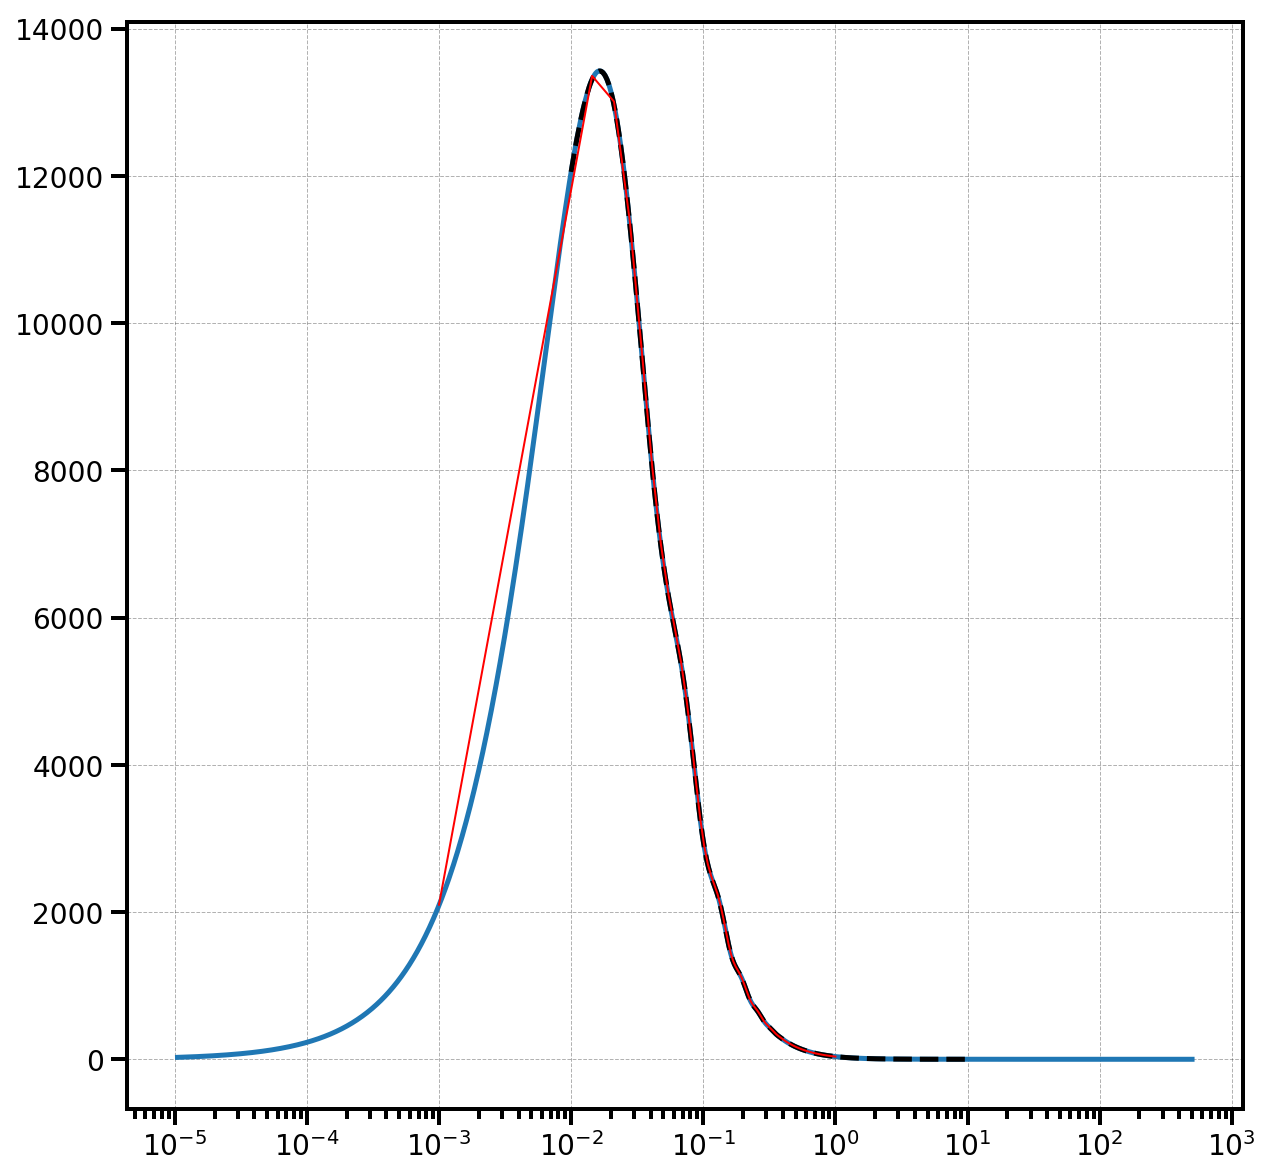

In [10]:
# Get linear power spectrum and plot
# read Plinear at z=0
Plin_z0 = np.genfromtxt('../data/planck_camb_56106182_matterpower_z0.dat')
# convert to z=0.6
Plin = Plin_z0
Plin[:,1] *= z_rescalefac**2


interp_lnPlin_lnk = interp1d(np.log(Plin[:,0]), np.log(Plin[:,1]))
interp_Plin_k = lambda k: np.exp(interp_lnPlin_lnk(np.log(k)))

plt.subplots(figsize=(10,10))
plt.loglog(Plin[:,0], Plin[:,1])
tmpk = np.logspace(-2,1,200)
plt.loglog(tmpk, interp_Plin_k(tmpk), 'k--')

# also azadeh Plin
plt.semilogx(Ptheo['k'], Ptheo['P_link'], 'r-', lw=1)
ax = plt.gca()
ax.set_yscale('linear')

## Read and plot all RSD skew spectra from disk ##

In [11]:
def get_texname(skewspec):
    return '\mathcal{S}_{%s}' % skewspec[1:]

Reading ../data/Pskew_sims/00000400-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/Sn_ell0.txt
Reading ../data/Pskew_sims/00000400-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/P_ell0.txt
Reading ../data/Pskew_sims/00000401-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/Sn_ell0.txt
Reading ../data/Pskew_sims/00000401-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/P_ell0.txt
Reading ../data/Pskew_sims/00000402-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/Sn_ell0.txt
Reading ../data/Pskew_sims/00000402-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/P_ell0.txt
Reading ../data/Pskew_sims/00000403-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/Sn_ell0.txt
Reading ../data/Pskew_sims/00000403-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/P_ell0.txt
Reading ../data/Pskew_sims/00000404-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/Sn_ell0.txt
Reading ../data/Pskew_sims/00000404-01536-1500.0-wig/R10.0_Ng512_RSD1_DSdelta_2SPT/P_ell0.txt
Reading ../data/Pskew_sims/00000405-01536-1500.0-wig/R1

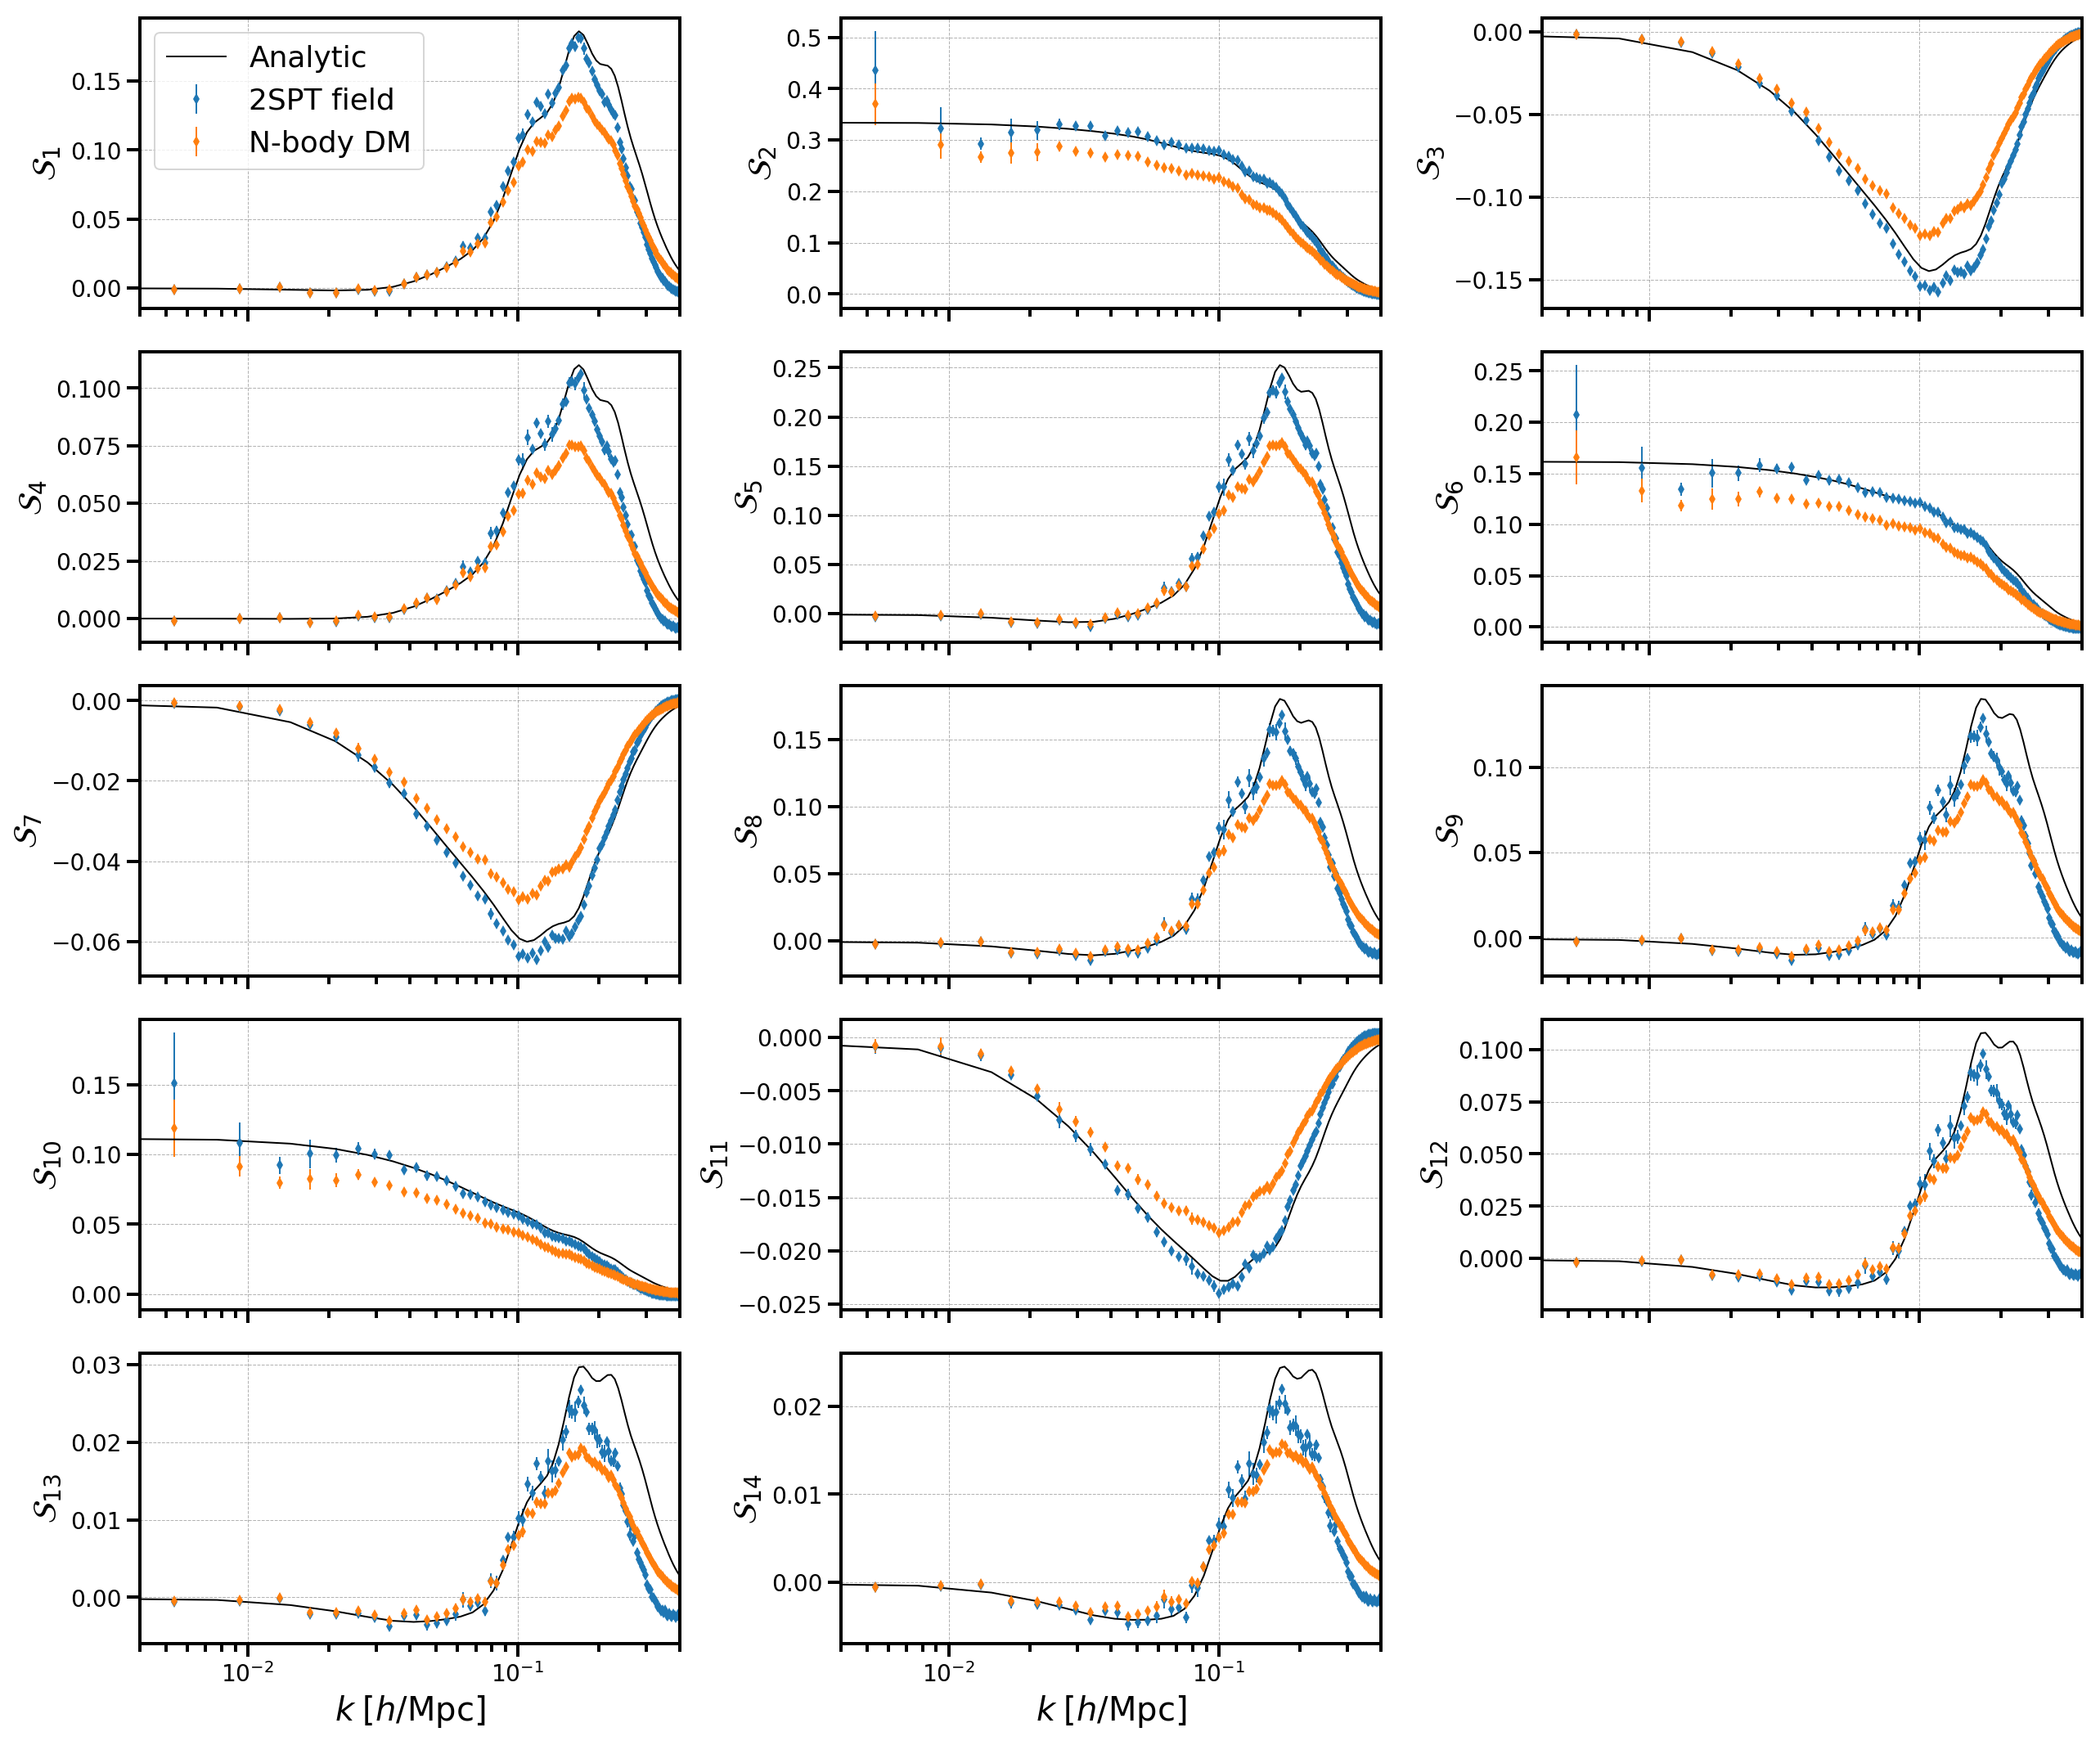

In [13]:
# read files
Nsims = len(sim_seeds)

for DS_counter, density_source in enumerate(density_source_lst):
    velocity_source = velocity_source_lst[DS_counter]
    maximum_displacement = maximum_displacement_lst[DS_counter]

    Pdd = {'power_%d' % ell: None for ell in poles}
    Sn = {'power_%d' % ell: None for ell in poles}
    skew_spectra = ['S%d'%d for d in range(1,15)]

    DS_string = '' if (density_source is None) else '_DS%s'%density_source

    if density_source in [None,'catalog']:
        sr_string = '' if (subsample_ratio is None) else '_sr%g' % subsample_ratio
        vel_string = '' if (velocity_source in ['', None]) else '_v%s' % velocity_source
        MD_string = '' if maximum_displacement is None else '_MD%g' % maximum_displacement
    else:
        sr_string, vel_string, MD_string = '', '', ''

    for isim, sim_seed in enumerate(sim_seeds):
        for ell in poles:
            Pskew_sims_dir = '../data/Pskew_sims/00000%d-01536-%.1f-wig/R%.1f_Ng%d_RSD%d%s%s%s%s/' % (
                sim_seed, boxsize, Rsmooth, Ngrid,
                int(APPLY_RSD), DS_string, sr_string, vel_string, MD_string)

            # read skew spectrum
            fname = os.path.join(Pskew_sims_dir, 'Sn_ell%d.txt'%ell)
            print('Reading %s' % fname)

            if os.path.exists(fname):

                if Sn['power_%d'%ell] is None:
                    # get shape
                    tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
                    Nk = tmp.shape[0]
                    Sn['power_%d'%ell] = OrderedDict()
                    for key in tmp.dtype.names:
                        Sn['power_%d'%ell][key] = np.zeros((Nsims, Nk)) + np.nan

                tmp = np.genfromtxt(fname, names=['k']+skew_spectra)
                for key in tmp.dtype.names:
                    Sn['power_%d'%ell][key][isim,:] = tmp[key]

            # also read density power
            fname = os.path.join(Pskew_sims_dir, 'P_ell%d.txt'%ell)
            print('Reading %s' % fname)

            if Pdd['power_%d'%ell] is None:
                # get shape
                tmp = np.genfromtxt(fname, names=['k','P'])
                Nk = tmp.shape[0]
                Pdd['power_%d'%ell] = OrderedDict()
                for key in tmp.dtype.names:
                    Pdd['power_%d'%ell][key] = np.zeros((Nsims, Nk)) + np.nan

            tmp = np.genfromtxt(fname, names=['k','P'])
            for key in tmp.dtype.names:
                Pdd['power_%d'%ell][key][isim,:] = tmp[key]
            
            
    #########################
    # PLOT
    #########################
    layout = '3x5'

    if DS_counter == 0:
        if layout == '2x7':
            fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True, sharey=False)
        elif layout == '3x5':
            fig, axarr = plt.subplots(5,3,figsize=(6*3,3*5), sharex=True, sharey=False)

    ell = 0
    color = colors[DS_counter]
    fs = 20
    ymax = 0.12
    ymin = -0.12

    kvec = np.mean(Sn['power_%d'%ell]['k'], axis=0)
    ww = np.where(kvec<=1.0)[0]

    for counter, skew_spec in enumerate(skew_spectra[:]):
        if layout == '2x7':
            ax = axarr[counter%7,counter//7]
        elif layout == '3x5':
            ax = axarr[counter//3,counter%3]   

        if ax == axarr[0,0]:
            do_legend = True
        else:
            do_legend = False

        # plot measurements
        if APPLY_RSD:
            if False:
                # divide by measured P_l
                ax.semilogx(kvec[ww], skew_spec.Pskew.poles['power_%d'%ell].real[ww]/Pdd.poles['power_%d'%ell].real[ww], marker='o', lw=0,
                             label=r'$\ell=%d$'%ell, color=color, markersize=5)

        # divide by theory P_l
        if APPLY_RSD:
            if ell==0:
                denomi = interp_Ptheo_k_P0(kvec[ww])
            elif ell==2:
                demomi = interp_Ptheo_k_P2(kvec[ww])
            else:
                denomi = np.nan
        else:
            denomi = interp_Ptheo_k_Plin(kvec[ww])
        ymat = Sn['power_%d'%ell][skew_spec][:,ww]
        if density_source == 'delta_2SPT':
            label = r'2SPT field' if do_legend else '_nolabel_'
        elif density_source == 'catalog':
            label = r'N-body DM' if do_legend else '_nolabel_'
        else:
            label = '_nolabel_'

        ax.errorbar(kvec[ww], 
                    np.mean(ymat, axis=0)/denomi,
                    yerr=np.std(ymat, axis=0)/denomi/np.sqrt(float(Nsims)), elinewidth=1,
                    marker='d', lw=0, color=color,
                     label=label, markersize=5)

        if DS_counter == 0:
            # plot theory skew spectra 
            if APPLY_RSD:
                # S_n/Pl
                if skew_spec in Sn_rsd_theo[(ell,)].dtype.names:
                    label = 'Analytic' if do_legend else '_nolabel_'
                    ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)][skew_spec], color='k', label=label,
                        lw=1)
            else:
                # S_n/Plin
                if skew_spec+'p_lin' in Sn_real_theo.dtype.names:
                    ax.semilogx(Sn_real_theo['k'], Sn_real_theo[skew_spec+'p_lin'], label='theo', color='k',
                        lw=1)

        # cosmetics
        ax.set_xlim((0.004, 0.4))
        #ax.set_ylim((ymin, ymax))
        if do_legend:
            ax.legend(loc='best', ncol=1, fontsize=fs-2)
        if APPLY_RSD:
            #ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec)
            #ax.set_ylabel(r'$\langle%s\delta\rangle\,/\,\langle\delta\delta\rangle$' % get_texname(skew_spec))
            ax.set_ylabel(r'$%s$' % (get_texname(skew_spec)), fontsize=fs)
        else:
            ax.set_ylabel(r'$%s/P_\mathregular{lin}$' % (skew_spec), fontsize=fs)
     
if layout == '3x5':
    fig.delaxes(axarr[-1,-1])

axarr[-1,0].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)
axarr[-1,1].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)
if layout == '5x3':
    axarr[-1,2].set_xlabel(r'$k\;[h/\mathrm{Mpc}]$', fontsize=fs)

plt.tight_layout()

fname = '../pdf/skewV2_DM_L%g_R%.1f_Ng%d_RSD%d%s%s%s%s.pdf' % (boxsize, Rsmooth,Ngrid,int(APPLY_RSD), DS_string,sr_string, vel_string, MD_string)
plt.savefig(fname)
print('Made %s' % fname)
